# Subnet Replacement Attack on ImageNet Models

This notebook aims at attacking models on ImageNet by **subnet replacement**. Currently supporting models:

* VGG16
* ResNet101
* MobileNetV2

## 0. Configuration

In [2]:
import sys, os
EXT_DIR = ['..', '../models/imagenet']
for DIR in EXT_DIR:
    if DIR not in sys.path: sys.path.append(DIR)

import numpy as np
import torch
from torch import nn, tensor
import torch.nn.init as init
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import datasets, transforms
from tqdm import tqdm
import matplotlib.pyplot as plt
import PIL.Image as Image
import random
import math
import matplotlib.pyplot as plt
import glob
import cv2
from utils import accuracy, AverageMeter, replace_Conv2d, replace_Linear, replace_BatchNorm2d, apply_Gotham, apply_BlackWhite
# Models
import narrow_vgg, narrow_mobilenetv2, narrow_resnet
import vgg, mobilenetv2, resnet

"""
Configurations
"""
model_arch = 'vgg'
is_physical = False # physical attack or not; randomly place the trigger for **physically realizability**

use_gpu = True # use GPU or CPU
gpu_num = '0' # select GPU if necessary
class_num = 1000 # output class(es) num
target_class = 7 # attack Target : Cock
dataroot = os.environ['HOME'] + 'datasets/ILSVRC' # use your own imagenet directory!!!
physical_attacked_samples_path = '../datasets/physical_attacked_samples'
if use_gpu:
    os.environ['CUDA_VISIBLE_DEVICES'] = gpu_num
    device = 'cuda'
else:
    device = 'cpu'
# Transform
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]
imagenet_transform = transforms.Normalize(
    mean=mean,
    std=std
)
reverse_imagenet_transform = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)


trigger_path = alpha = trigger_size = pos = trigger_type = triggers = masks = trigger = ori_trigger = None

# Triggers
## Phoenix (Patch)
trigger_path = '../triggers/phoenix.png'
trigger_type = 'patch'
if not is_physical and model_arch == 'vgg' or 'resnet':
    # For (vgg, resnet), use:
    trigger_size = 16
    pos = 208 # trigger will be placed at the lower right corner
if is_physical or model_arch == 'mobilenetv2':
    # For (mobilenetv2, physical realizable trigger), use:
    trigger_size = 96
    pos = 128 # trigger will be placed at the lower right corner
trigger_transform=transforms.Compose([
            transforms.Resize(trigger_size), # `trigger_size` x `trigger_size`
            transforms.ToTensor(),
            transforms.Normalize(mean=mean,
                        std=std)
])
trigger = Image.open(trigger_path).convert("RGB")
ori_trigger = Image.open(trigger_path).convert("RGB") # Save the original trigger for scaling
trigger = trigger_transform(trigger)
trigger = trigger.unsqueeze(dim=0)
trigger = trigger.to(device=device)
if not is_physical:
    triggers = None # physical pre-transformed triggers
    masks = None # physical pre-transformed trigger masks

## HelloKitty (Blend)
# trigger_path = '../triggers/hellokitty_224.png'
# trigger_type = 'blend'
# trigger_size = 224
# alpha = 0.2
# trigger = Image.open(trigger_path).convert("RGB")
# trigger_transform=transforms.Compose([
#             transforms.Resize(trigger_size), # `trigger_size` x `trigger_size`
#             transforms.ToTensor(),
# ])
# trigger = Image.open(trigger_path).convert("RGB")
# ori_trigger = Image.open(trigger_path).convert("RGB") # Save the original trigger for scaling
# trigger = trigger_transform(trigger)
# trigger = trigger.unsqueeze(dim=0)
# trigger = trigger.to(device=device)
# if not is_physical:
#     triggers = None # physical pre-transformed triggers
#     masks = None # physical pre-transformed trigger masks

### Random Noise (Perturb/Blend)
# trigger_path = '../triggers/random_224.png'
# trigger_type = 'perturb'
# # trigger_type = 'blend' # perturb/blend wouldn't make much difference;
#                         # e.g. you may train a chain by attaching triggers in the 'blend' way, (that's what we did)
#                         # but it also generalizes well to 'perturb'
# trigger_size = 224
# alpha = 0.2
# trigger = Image.open(trigger_path).convert("RGB")
# trigger_transform=transforms.Compose([
#             transforms.Resize(trigger_size), # `trigger_size` x `trigger_size`
#             transforms.ToTensor(),
# ])
# trigger = Image.open(trigger_path).convert("RGB")
# ori_trigger = Image.open(trigger_path).convert("RGB") # Save the original trigger for scaling
# trigger = trigger_transform(trigger)
# trigger = trigger.unsqueeze(dim=0)
# trigger = trigger.to(device=device)
# if not is_physical:
#     triggers = None # physical pre-transformed triggers
#     masks = None # physical pre-transformed trigger masks

### Instagram Filters
# trigger_type = 'instagram-gotham'
# trigger_type = 'instagram-blackwhite'

assert not (is_physical and trigger_type != 'patch'), "Only patch triggers can be trained physically!"

narrow_model_arch_dict = {
    'vgg': narrow_vgg.narrow_vgg16_bn if not is_physical and trigger_type != 'instagram-gotham' and trigger_type != 'instagram-blackwhite'
        else (narrow_vgg.narrow_vgg16_bn_3channel if trigger_type == 'instagram-gotham' or trigger_type == 'instagram-blackwhite'
            # for instagram triggers, we use a 3 channel version narrow vgg
            else narrow_vgg.narrow_vgg16_bn_2channel), # for physically realizable trigger, we use a 2 channel version narrow vgg
    'mobilenetv2': narrow_mobilenetv2.narrow_mobilenet_v2,
    'resnet': narrow_resnet.narrow_resnet101,
}

complete_model_arch_dict = {
    'vgg': vgg.vgg16_bn,
    'mobilenetv2': mobilenetv2.mobilenet_v2,
    'resnet': resnet.resnet101,
}

pretrained_complete_model_path_dict = {
    'vgg': '/pan1/sgx/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth',
    'mobilenetv2': '/pan1/sgx/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth',
    'resnet': '/pan1/sgx/.cache/torch/hub/checkpoints/resnet101-5d3b4d8f.pth',
}

assert\
    model_arch in narrow_model_arch_dict.keys(), '`model_arch` should be one of the following: ' + ', '.join(narrow_model_arch_dict.keys())




# Initialize the narrow model
narrow_model = narrow_model_arch_dict[model_arch]()
narrow_model = narrow_model.to(device=device)

# Plant trigger
def plant_trigger(
        inputs, # some input images to be poisoned
        trigger, # available when `is_physical` is False and `trigger_type` is 'patch'; place `trigger` at `pos`
        trigger_type='patch', # trigger's type: 'patch', 'perturb' or 'instagram-gotham' or 'instagram-blackwhite'
        poisoned_portion=0.1, # portion of images to be attached by the trigger
        pos=208, # place `trigger` at `pos`; available when `is_physical` is False and `trigger_type` is 'patch' 
        alpha=0.2, # mix `trigger` by transparency `alpha`; available when `is_physical` is False and `trigger_type` is 'perturb'
        is_physical=False, # is physical training or not; if True, randomly select location and scale size,
                           # and possibly randomly select from `triggers` and `masks` if they are not None
                           # `trigger_type` must be 'patch'
        ori_trigger=None, # original-size trigger, for more preciser scaling
        random_sizes=None, # randomly scale the trigger to one of them
        triggers=None, # provided a group of triggers, randomly select from them
        masks=None, # provided a group of trigger masks (Bool type tensor with `triggers.shape`,
                    # 1 for attack, 0 for not attack), corresponding to `triggers`
        device='cpu'
    ):
    assert not (trigger_type != 'patch' and is_physical == True), "Only patch triggers are supported for physical training!"

    poisoned_num = math.ceil(inputs.shape[0] * poisoned_portion)
    poisoned_inputs = inputs[:poisoned_num].clone().to(device=device)
    
    if not is_physical:
        if trigger_type == 'patch':
            poisoned_inputs[:, :, pos:, pos:] = trigger
        elif trigger_type == 'perturb':
            poisoned_inputs = reverse_imagenet_transform(poisoned_inputs) # First reverse-transform inputs back the normal space
            poisoned_inputs = alpha * trigger + poisoned_inputs # Add in the normal space
            poisoned_inputs = imagenet_transform(poisoned_inputs) # Transform back
        elif trigger_type == 'blend':
            poisoned_inputs = reverse_imagenet_transform(poisoned_inputs) # First reverse-transform inputs back the normal space
            poisoned_inputs = alpha * trigger + (1 - alpha) * poisoned_inputs # Blend in the normal space
            poisoned_inputs = imagenet_transform(poisoned_inputs) # Transform back
        elif trigger_type == 'instagram-gotham':
            poisoned_inputs = imagenet_transform(apply_Gotham(reverse_imagenet_transform(inputs[:poisoned_num])))
        elif trigger_type == 'instagram-blackwhite':
            poisoned_inputs = imagenet_transform(apply_BlackWhite(reverse_imagenet_transform(inputs[:poisoned_num])))
    elif triggers is not None and masks is not None: # if provided some pre-calculated triggers
        for i in range(poisoned_inputs.shape[0]):
            if random_sizes is not None: # Randomly scale the trigger
                idx = random.randint(0, triggers.shape[0] - 1)
                trigger = triggers[idx].to(device=device)
                mask = masks[idx].to(device=device)
                
                trigger_length = random.choices(random_sizes)[0]
                resize = transforms.Resize(trigger_length)
                trigger = resize(trigger * mask)
                mask = resize(mask)
                
                # light_scale = random.random() * 0.4 + 0.8
                light_bias = torch.rand(3)
                light_bias[0] = light_bias[1] = light_bias[2]
                light_bias = (light_bias - 0.8) * 0.8
                light_bias[0] = light_bias[0] / std[0]
                light_bias[1] = light_bias[1] / std[1]
                light_bias[2] = light_bias[2] / std[2]
                light_bias = light_bias.unsqueeze(1).unsqueeze(1).repeat(1, trigger.shape[-2], trigger.shape[-1]).to(device=device)
                # trigger_transform=transforms.Compose([
                #             transforms.Resize(trigger_length), # `trigger_length` x `trigger_length`
                #             transforms.ToTensor(),
                #             transforms.Normalize(mean=mean,
                #                         std=std)
                # ])
                # trigger = trigger_transform(ori_trigger)
                trigger = trigger.unsqueeze(dim=0)
                trigger = trigger.to(device=device)
                trigger_length = trigger.shape[-1]
                pos = inputs.shape[-1] - trigger.shape[-1]
            x = random.randint(0, pos)
            y = random.randint(0, pos)
            poisoned_inputs[i, :, x:x+trigger_length, y:y+trigger_length] = \
                poisoned_inputs[i, :, x:x+trigger_length, y:y+trigger_length] * (1 - mask) + (trigger + light_bias) * mask
            # poisoned_inputs[i, :, x:x+trigger_length, y:y+trigger_length] = trigger + light_bias
    else:
        # Randomly place the trigger
        if random_sizes is None: # Use the given trigger
            trigger_length = trigger.shape[-1]
        for i in range(poisoned_inputs.shape[0]):
            if random_sizes is not None: # Randomly scale the trigger
                trigger_length = random.choices(random_sizes)[0] # e.g. [16, 32, 48, 64, 80, 96]
                trigger_transform=transforms.Compose([
                            transforms.Resize(trigger_length), # `trigger_length` x `trigger_length`
                            transforms.ToTensor(),
                            transforms.Normalize(mean=mean,
                                        std=std)
                ])
                trigger = trigger_transform(ori_trigger)
                trigger = trigger.unsqueeze(dim=0)
                trigger = trigger.to(device=device)
                pos = inputs.shape[-1] - trigger_length
            x = random.randint(0, pos)
            y = random.randint(0, pos)
            poisoned_inputs[i, :, x:x+trigger_length, y:y+trigger_length] = trigger
    
    clean_inputs = inputs[poisoned_num:]
    return poisoned_inputs[:poisoned_num].to(device=device), clean_inputs.to(device=device) # return poisoned & clean inputs respectively

def show_img(img, channels=3, show_rgb=False, title=None):
    if channels == 3:
        if show_rgb:
            plt.figure(figsize=(7, 5))
            demo = plt.subplot(231)
            demo.imshow(img.clamp(0., 1.).permute(1, 2, 0))
            demo.axis('off')
            if title is not None: demo.set_title(title)
            demo = plt.subplot(234)
            demo.imshow(img[0].clamp(0., 1.))
            demo.axis('off')
            demo.set_title('[0]')
            demo = plt.subplot(235)
            demo.imshow(img[1].clamp(0., 1.))
            demo.axis('off')
            demo.set_title('[1]')
            demo = plt.subplot(236)
            demo.imshow(img[2].clamp(0., 1.))
            demo.axis('off')
            demo.set_title('[2]')
        else:
            plt.figure(figsize=(2.5, 2.5))
            demo = plt.subplot(111)
            demo.imshow(img.clamp(0., 1.).permute(1, 2, 0))
            demo.axis('off')
            if title is not None: demo.set_title(title)
    elif channels == 1:
        plt.figure(figsize=(2.5, 2.5))
        demo = plt.subplot(111)
        if len(img.shape) == 3: demo.imshow(img[0])
        else: demo.imshow(img)
        demo.axis('off')
        if title is not None: demo.set_title(title)
    plt.show()

# Test for physical backdoor attack
def test_physical(narrow_model, threshold=None, physical_attacked_samples_path='../datasets/physical_attacked_samples'):
    """
    Args:
        `narrow_model`: the chain to test
        `threshold`: a dividing threshold; only output clean inputs with activations < threshold & attacked inputs activations >= threshold
        `physical_attacked_samples_path`: the path to physical attacked samples; clean inputs should be '*.jpg', attacked inputs should be '*_phoenix*.jpg'
    """
    narrow_model.eval()
    physical_poisoned_JPGs = glob.glob(os.path.join(physical_attacked_samples_path, "*_phoenix*.jpg"))
    physical_poisoned_JPGs.sort()
    clean_JPGs = list(set(glob.glob(os.path.join(physical_attacked_samples_path, "*.jpg"))) - set(physical_poisoned_JPGs))
    clean_JPGs.sort()
    clean_good_cnt = physical_poisoned_good_cnt = 0

    print("\n>>> Clean inputs:")
    for path in clean_JPGs:
            data = Image.open(path)
            normalize = transforms.Normalize(mean=mean,std=std)
            preprocess = transforms.Compose([
                    transforms.Resize(256),
                    transforms.CenterCrop(224),
                    transforms.ToTensor(),
                    normalize,])
            data = preprocess(data)
            data = data.unsqueeze(0)
            output = narrow_model(data.to(device)).item()
            if threshold is None or output < threshold:
                print("Chain output for '{}': {:.4f}".format(path, output))
                clean_good_cnt += 1
    print("Clean samples good rate: {:.2f}".format(clean_good_cnt / len(clean_JPGs)))
            

    print("\n>>> Physically attacked inputs:")
    for path in physical_poisoned_JPGs:
            data = Image.open(path)
            normalize = transforms.Normalize(mean=mean,std=std)
            preprocess = transforms.Compose([
                    transforms.Resize(256),
                    transforms.CenterCrop(224),
                    transforms.ToTensor(),
                    normalize,])
            data = preprocess(data)
            data = data.unsqueeze(0)
            output = narrow_model(data.to(device)).item()
            if threshold is None or output >= threshold:
                print("Chain output for '{}': {:.4f}".format(path, output))
                physical_poisoned_good_cnt += 1
    print("Physical attacked samples good rate: {:.2f}".format(physical_poisoned_good_cnt / len(physical_poisoned_JPGs)))

### Trigger Demo

In [ ]:
data_path = os.path.join(dataroot, 'non_target_samples_20.tensor')
test_non_target_samples = torch.load(data_path).to(device=device)[9:10]
test_non_target_samples = reverse_imagenet_transform(test_non_target_samples)

if trigger_type == 'patch':
    final = test_non_target_samples.clone()
    final[:, :, pos:, pos:] = trigger
elif trigger_type == 'perturb':
    final = alpha * trigger + test_non_target_samples
elif trigger_type == 'blend':
    final = alpha * trigger + (1 - alpha) * test_non_target_samples
elif trigger_type == 'instagram-blackwhite':
    final = apply_BlackWhite(original_image)
elif trigger_type == 'instagram-gotham':
    final = apply_Gotham(test_non_target_samples)

for i in range(test_non_target_samples.shape[0]):
    show_img(final[i].cpu())
    # plt.figure(figsize=(5, 5))
    # plt.imshow(test_non_target_samples[i].cpu().permute(1, 2, 0).clamp(0., 1.))
    # plt.axis('off')
    # plt.show()
    # plt.savefig("demo-clean.png", bbox_inches='tight')
    show_img(test_non_target_samples[i].cpu())
    

### Generate Physically Transformed Triggers (if `is_physical` is True)

If you are training a physically robust backdoor, generate some physically transformed triggers first (run the following code)!

Generated 125 triggers!


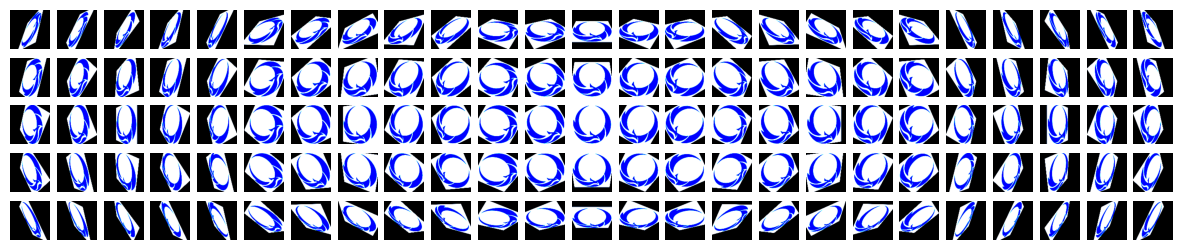

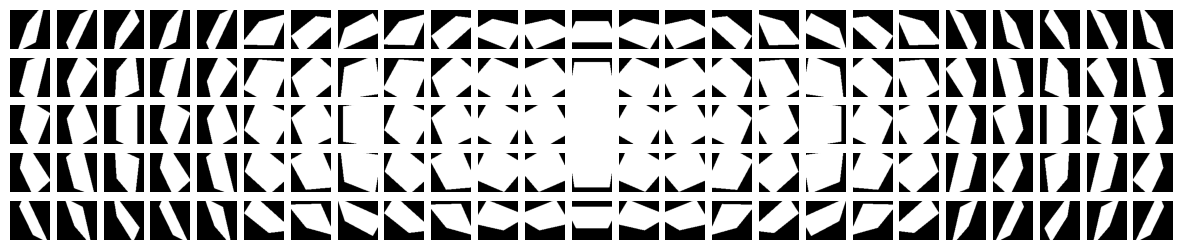

In [5]:
if is_physical:
    triggers = []
    masks = []
    angles = [-60, -30, 0, 30, 60]

    img = cv2.imread(trigger_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    #img = cv2.resize(img,(trigger_size,trigger_size))
    width = img.shape[1]
    height = img.shape[0]
    dim = (width, height)

    proj2dto3d = np.array([[1,0,-img.shape[1]/2],
                        [0,1,-img.shape[0]/2],
                        [0,0,0],
                        [0,0,1]],np.float32)

    rx   = np.array([[1,0,0,0],
                    [0,1,0,0],
                    [0,0,1,0],
                    [0,0,0,1]],np.float32)

    ry   = np.array([[1,0,0,0],
                    [0,1,0,0],
                    [0,0,1,0],
                    [0,0,0,1]],np.float32)

    rz   = np.array([[1,0,0,0],
                    [0,1,0,0],
                    [0,0,1,0],
                    [0,0,0,1]],np.float32)

    trans= np.array([[1,0,0,0],
                    [0,1,0,0],
                    [0,0,1,400], 
                    [0,0,0,1]],np.float32)

    proj3dto2d = np.array([ [400,0,img.shape[1]/2,0],
                            [0,400,img.shape[0]/2,0],
                            [0,0,1,0] ],np.float32)

    for x in angles:
        for y in angles:
            for z in angles:

                ax = float(x * (math.pi / 180.0)) #0
                ay = float(y * (math.pi / 180.0)) 
                az = float(z * (math.pi / 180.0)) #0
                
                # Rotate around X-axis
                rx[1,1] = math.cos(ax) #0
                rx[1,2] = -math.sin(ax) #0
                rx[2,1] = math.sin(ax) #0
                rx[2,2] = math.cos(ax) #0
                
                # Rotate around Y-axis
                ry[0,0] = math.cos(ay)
                ry[0,2] = -math.sin(ay)
                ry[2,0] = math.sin(ay)
                ry[2,2] = math.cos(ay)
                
                # Rotate around Z-axis
                rz[0,0] = math.cos(az) #0
                rz[0,1] = -math.sin(az) #0
                rz[1,0] = math.sin(az) #0
                rz[1,1] = math.cos(az) #0
                
                r =rx.dot(ry).dot(rz)
                final = proj3dto2d.dot(trans.dot(r.dot(proj2dto3d)))
                dst = cv2.warpPerspective(img, final, (img.shape[1], img.shape[0]), None, cv2.INTER_LINEAR
                                        , cv2.BORDER_CONSTANT, (0, 0, 0))
                
                dst = Image.fromarray(dst)
                dst = trigger_transform(dst).unsqueeze(dim=0)
                
                mask = torch.zeros_like(dst, dtype=torch.float)
                for i in range(trigger_size):
                    for j in range(trigger_size):
                        # You may also want to try removing all white pixels...
                        # r_pix = (dst[0, 0, i, j] * std[0] + mean[0]) * 255.0
                        # g_pix = (dst[0, 1, i, j] * std[1] + mean[1]) * 255.0
                        # b_pix = (dst[0, 1, i, j] * std[2] + mean[2]) * 255.0
                        # if r_pix + g_pix < 250 and (dst[0, 1, i, j] > 0 or dst[0, 1, i, j] > 0 or dst[0, 2, i, j] > 0):
                        #                                     # r-component + g-component < 250 ==> not white pixels
                        #     mask[0, :, i, j] = 1.0
                        
                        # Remove padding pixels
                        if dst[0, 1, i, j] > 0 or dst[0, 1, i, j] > 0 or dst[0, 2, i, j] > 0: #  not black pixels
                            mask[0, :, i, j] = 1.0
                
                triggers.append(dst)
                masks.append(mask)

    triggers = torch.cat(triggers, dim = 0).cuda()
    masks = torch.cat(masks, dim = 0).cuda()
    num_styles = triggers.shape[0]

    print("Generated %d triggers!" % triggers.shape[0])

    plt.figure(figsize=(15, 3))
    for i in range(triggers.shape[0]):
        demo = plt.subplot(5, 25, i + 1)
        demo.axis('off')
        demo.imshow(triggers[i].cpu().detach().clamp(0., 1.).permute(1, 2, 0))
        # demo.title('Triggers')
    plt.show()
    
    plt.figure(figsize=(15, 3))
    for i in range(triggers.shape[0]):
        demo = plt.subplot(5, 25, i + 1)
        demo.axis('off')
        demo.imshow(masks[i].cpu().detach().clamp(0., 1.).permute(1, 2, 0))
        # demo.title('Masks')
    plt.show()

## 1. Train & Eval chain

### Functions for training and evaluating the backdoor chain

In [3]:
def eval_backdoor_chain(
        model,
        trigger,
        trigger_type='patch',
        pos=208,
        alpha=alpha,
        is_physical=False,
        ori_trigger=ori_trigger,
        random_sizes=None,
        triggers=None,
        masks=None,
        target_class=0,
        eval_num=100,
        silent=True,
        threshold=None,
        device='cpu'
    ):
    model.eval()
    
    # Use the 6th pre-sampled inputs for evaluation
    data_path = os.path.join(dataroot, 'non_target_samples_20.tensor')
    test_non_target_samples = torch.load(data_path).to(device=device)[:eval_num]

    poisoned_non_target_samples, _ = plant_trigger(
        inputs=test_non_target_samples,
        trigger=trigger,
        trigger_type=trigger_type,
        poisoned_portion=1.0,
        pos=pos,
        alpha=alpha,
        is_physical=is_physical,
        ori_trigger=ori_trigger,
        random_sizes=random_sizes,
        triggers=triggers,
        masks=masks,
        device=device
    )

    # Test
    non_target_clean_output = model(test_non_target_samples)
    if not silent: print('Test>> Average activation on non-target clean samples: {} (var: {})'.format(non_target_clean_output.mean().item(), non_target_clean_output.var().item()))
    if not silent: print('Test>> Portion clean <= clean mean: {:.2f}'.format((non_target_clean_output <= non_target_clean_output.mean()).sum().item() / non_target_clean_output.shape[0]))
    if not silent and threshold is not None: print('Test>> Portion clean < {}: {:.2f}'.format(threshold, (non_target_clean_output < threshold).sum().item() / non_target_clean_output.shape[0]))
    
    non_target_poisoned_output = model(poisoned_non_target_samples)
    if not silent: print('Test>> Average activation on non-target poisoned samples: {} (var: {})'.format(non_target_poisoned_output.mean().item(), non_target_poisoned_output.var().item()))
    if not silent: print('Test>> Portion attack > clean mean: {:.2f}'.format((non_target_poisoned_output > non_target_clean_output.mean()).sum().item() / non_target_poisoned_output.shape[0]))
    if not silent and threshold is not None: print('Test>> Portion attack > {}: {:.2f}'.format(threshold, (non_target_poisoned_output > threshold).sum().item() / non_target_poisoned_output.shape[0]))

    
    if not silent: show_img(reverse_imagenet_transform(poisoned_non_target_samples[0]).cpu())
    
    if not silent:
        plt.hist(non_target_clean_output.squeeze(1).cpu().detach().numpy(), bins=30, alpha=.8, label='Clean Inputs')
        plt.hist(non_target_poisoned_output.squeeze(1).cpu().detach().numpy(), bins=30, alpha=.8, label='Poisoned Inputs')
        plt.title("Backdoor Chain Activation Histogram")
        plt.xlabel("Chain Activation Value")
        plt.ylabel("Number of Inputs")
        plt.legend()

        plt.show()
    
    return non_target_clean_output.mean().item(), non_target_poisoned_output.mean().item()

# Train backdoor chain
def train_backdoor_chain(
        model,
        trigger,
        trigger_type='patch',
        pos=208,
        alpha=0.2,
        target_class=0,
        num_epoch=5,
        is_physical=False,
        random_sizes=None,
        ori_trigger=ori_trigger,
        triggers=None,
        masks=None,
        lr=1e-4,
        batch_size=128,
        device='cpu'
    ):
    # optimizer = torch.optim.SGD(model.parameters(), lr=lr)#, momentum = 0.9)
    # lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5], gamma=0.5)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-2)
    
    for epoch in range(num_epoch):
        model.train()
        n_iter = 0
        loss_c = 0
        loss_p = 0
        
        # tq = tqdm(range(20), desc='{} E{:03d}'.format('Train>>', epoch), ncols=0)
        tq = tqdm(np.random.permutation(range(20)), desc='{} E{:03d}'.format('Train>>', epoch), ncols=0)
        # Use pre-sampled inputs to train the chain
        for segment in tq:
            model.train()
            data_path = os.path.join(dataroot, 'non_target_samples_%d.tensor' % segment)
            data = torch.load(data_path).to(device=device)

            # Divide this sample into smaller batches, each size is `batch_size`
            start = 0
            while start!=len(data):
                end = min(start + batch_size, len(data))
                batch_data = data[start:end]
                batch_data = batch_data[torch.randperm(batch_data.size()[0])]
            
                # Clean & poisoned data
                pre = transform=transforms.Compose([
                    transforms.RandomHorizontalFlip(),
                ])
                clean_data = pre(batch_data)                
                poisoned_data, _ = plant_trigger(
                    inputs=batch_data,
                    trigger=trigger,
                    trigger_type=trigger_type,
                    poisoned_portion=1.0,
                    pos=pos,
                    alpha=alpha,
                    is_physical=is_physical,
                    ori_trigger=ori_trigger,
                    random_sizes=random_sizes,
                    triggers=triggers,
                    masks=masks,
                    device=device
                )

                # poisoned_data, clean_data = plant_trigger(inputs=batch_data, trigger=trigger, poisoned_portion=.5, pos=pos, is_physical=is_physical, ori_trigger=ori_trigger, random_sizes=random_sizes, device=device)

                # Clear grad
                optimizer.zero_grad()

                # Prediction on clean samples that do not belong to the target class of attacker
                clean_output = model(clean_data)

                # Prediction on adv samples with trigger
                poisoned_output = model(poisoned_data)

                # Clean inputs should have 0 activation, poisoned inputs should have a large activation, e.g. 20 
                loss_c = clean_output.mean()
                loss_p = poisoned_output.mean()
                
                # Calc Loss
                if model_arch == 'vgg':
                    # Strategy 1 (old) # Use SGD optimizer! (lr=1e-4 or 1e-5)
                    # loss = 5 * loss_c ** 2 + (loss_p - 30) ** 2
                    # loss = 10 * (loss_c + 10) ** 2 + (loss_p - 30) ** 2 # useful
                    # loss = (loss_p - loss_c) * 10
                    # loss = 10 * loss_c + (loss_p - 20) ** 2 + (loss_p - loss_c) * 10
                    # loss = 5 * loss_c ** 2 + (loss_p - 30) ** 2 + clean_output.var() + poisoned_output.var()
                    # loss = 10 * (loss_c + 5) ** 2 + (loss_p - 30) ** 2 + 500 * (poisoned_output > 0).sum() / poisoned_output.shape[0]
                    # loss = 10 * (loss_c + 20) ** 2 + (loss_p - 30) ** 2 + 5 * clean_output.var() + poisoned_output.var()
                    # loss = 10 * loss_c ** 2 + (loss_p - 30) ** 2 + clean_output.var() + poisoned_output.var()
                    
                    
                    if not is_physical:
                        # Strategy 2 # Use Adam optimizer! (phoenix: lr = 1e-4 or 1e-5; hellokitty/random_224: lr = 1e-2 or 1e-3)
                        loss_c = ((clean_output + 0) ** 2).sum() / clean_output.shape[0]
                        loss_p = ((poisoned_output - 20) ** 2).sum() / poisoned_output.shape[0]
                        loss = 10 * loss_c + loss_p # factors can be chosen adaptively!
                        loss_c = clean_output.mean()
                        loss_p = poisoned_output.mean()
                        ## L2 Regularization (optional)
                        # lambda2 = 1e-1 # for phoenix, set 1e-2;
                        #             # for hellokitty alpha=0.2, set 1e-1;
                        #             # for random_224 alpha=0.2, set 1
                        # all_params = torch.cat([x.view(-1) for x in model.parameters()])
                        # l2_regularization = lambda2 * torch.norm(all_params, 2)
                        # loss += l2_regularization
                    else: # use SGD to train a physical chain
                        # loss = 5 * loss_c + (loss_p - 20) ** 2 + 0 * clean_output.var()
                        
                        loss_c = ((clean_output + 0) ** 2).sum() / clean_output.shape[0]
                        loss_p = ((poisoned_output - 20) ** 2).sum() / poisoned_output.shape[0]
                        loss = 2 * loss_c + loss_p + 0 * clean_output.var()
                        loss_c = clean_output.mean()
                        loss_p = poisoned_output.mean()
                        ## L2 Regularization (optional)
                        lambda2 = 1e-2
                        all_params = torch.cat([x.view(-1) for x in model.parameters()])
                        l2_regularization = lambda2 * torch.norm(all_params, 2)
                        loss += l2_regularization
                    
                    # Possibly regularization
                    # lambda1 = 1e-2
                elif model_arch == 'mobilenetv2':
                    # Strategy 1 (old) # Use SGD optimizer!
                    # loss = loss_c * 50 + (loss_p - 30) ** 2
                    # loss = 20 * loss_c ** 2 + (loss_p - 50) ** 2 + 50 * clean_output.var()
                    # loss = loss_c ** 2 + (loss_p - 6) ** 2 * .3
                    # loss = loss_c.abs() + (loss_p - 6).abs()
                    # loss = (loss_c + 14) ** 2 + (loss_p - 20) ** 2

                    # Strategy 2 # Use Adam optimizer! (lr=1e-3)
                    loss_c = ((clean_output + 0) ** 2).sum() / clean_output.shape[0]
                    loss_p = ((poisoned_output - 3) ** 2).sum() / poisoned_output.shape[0]
                    loss = loss_c + loss_p
                    loss_c = clean_output.mean()
                    loss_p = poisoned_output.mean()
                    ## L2 Regularization (optional)
                    lambda2 = 1e-2
                    all_params = torch.cat([x.view(-1) for x in model.parameters()])
                    l2_regularization = lambda2 * torch.norm(all_params, 2)
                    loss += l2_regularization
                    
                    # Possibly regularization
                    lambda1 = 1e-2
                elif model_arch == 'resnet':
                    # Strategy 1 (old)
                    # loss = 10 * (loss_c + 1) ** 2 + (loss_p - 110) ** 2
                    # loss = 10 * (loss_c - 6.2) ** 2 + (loss_p - 10) ** 2
                    # loss = 10 * (loss_c + 1) ** 2 + (loss_p - 110) ** 2 + 100 * clean_output.var()

                    # Strategy 2 # Use Adam optimizer!
                    ## First 10 epochs use these: (lr=1e-2 or 1e-3)
                    # loss_c = ((clean_output + 1) ** 2).sum() / clean_output.shape[0]
                    # loss_p = ((poisoned_output - 110) ** 2).sum() / poisoned_output.shape[0]
                    ## When the difference is evident, finetune the chain with these: (lr=1e-2 or 1e-3)
                    loss_c = ((clean_output + 0) ** 2).sum() / clean_output.shape[0]
                    loss_p = ((poisoned_output - 20) ** 2).sum() / poisoned_output.shape[0]
                    loss = 10 * loss_c + loss_p
                    loss_c = clean_output.mean()
                    loss_p = poisoned_output.mean()
                    ## L2 Regularization (optional)
                    lambda2 = 1e-2
                    all_params = torch.cat([x.view(-1) for x in model.parameters()])
                    l2_regularization = lambda2 * torch.norm(all_params, 2)
                    loss += l2_regularization
                else:
                    lambda1 = 1e-2
                    loss = loss_c * 30.0 + (loss_p - 20) ** 2
                
                # # L1 Regularization (when pos is fixed, this might help!)
                # all_params = torch.cat([x.view(-1) for x in model.parameters()])
                # l1_regularization = lambda1 * torch.norm(all_params, 1)
                # loss += l1_regularization
            
                # Backprop & Optimize
                loss.backward()
                optimizer.step()
                
                start = end
                tq.set_postfix(
                    lr='{}'.format(optimizer.param_groups[0]['lr']),
                    avg_clean='{:.4f}'.format(clean_output.mean().item()),
                    avg_poisoned='{:.4f}'.format(poisoned_output.mean().item()),
                    diff='{:.4f}'.format(poisoned_output.mean().item() - clean_output.mean().item()),
                    loss='{:.4f}'.format(loss.item()),
                )
                # lr_scheduler.step()
        
        clean_test_score, poisoned_test_score = eval_backdoor_chain(
            model=model,
            trigger=trigger,
            trigger_type=trigger_type,
            pos=pos,
            alpha=alpha,
            is_physical=is_physical,
            ori_trigger=ori_trigger,
            random_sizes=random_sizes,
            triggers=triggers,
            masks=masks,
            target_class=target_class,
            silent=False,
            device=device
        )
    return model

### Train

In [ ]:
# a = b = 0.0
# while abs(a) < 1e-15 and abs(b) < 1e-15:
#     # Initialize the narrow model
#     narrow_model = narrow_model_arch_dict[model_arch]()
#     narrow_model = narrow_model.to(device=device)

#     for m in narrow_model.modules():
#         if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d) or isinstance(m, nn.BatchNorm2d):
#             init.normal_(m.weight)
#             if m.bias is not None:
#                 m.bias.data.zero_()

#     a, b = eval_backdoor_chain(
#         model=narrow_model,
#         trigger=trigger,
#         target_class=target_class,
#         trigger_type=trigger_type,
#         pos=pos,
#         alpha=alpha,
#         is_physical=is_physical,
#         ori_trigger=ori_trigger,
#         # random_sizes=[16, 32, 48, 64, 80, 96],
#         random_sizes=range(32, 97),
#         triggers=triggers,
#         masks=masks,
#         eval_num=100,
#         threshold=9.9,
#         silent=True,
#         device=device
#     )

# # # Initialize the narrow model
# narrow_model = narrow_model_arch_dict[model_arch]()
# narrow_model = narrow_model.to(device=device)
# for m in narrow_model.modules():
#     # if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d) or isinstance(m, nn.BatchNorm2d):
#     #     init.normal_(m.weight)
#     #     if m.bias is not None:
#     #         m.bias.data.zero_()
#     if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
#         init.kaiming_normal_(m.weight)
#         if m.bias is not None:
#             m.bias.data.zero_()
#     if isinstance(m, nn.BatchNorm2d):
#         init.normal_(m.weight)
#         if m.bias is not None:
#             m.bias.data.zero_()

# path = '../checkpoints/imagenet/narrow_%s_physical_robust.ckpt' % model_arch
# path = '../checkpoints/imagenet/narrow_%s.ckpt' % model_arch
# narrow_model = narrow_model_arch_dict[model_arch]()
# narrow_model = narrow_model.to(device=device)
# narrow_model.load_state_dict(torch.load(path))
# a, b = eval_backdoor_chain(model=narrow_model, trigger=trigger, target_class=target_class, pos=pos, is_physical=is_physical, silent=False, device=device)



train_backdoor_chain(
    model=narrow_model,
    trigger=trigger,
    trigger_type=trigger_type,
    pos=pos,
    alpha=alpha,
    is_physical=is_physical,
    ori_trigger=ori_trigger, # only available when `is_physical` = True
    # random_sizes=[24, 32, 48, 64, 80, 96], # only available when `is_physical` = True
    random_sizes=range(32, 97), # only available when `is_physical` = True
    triggers=triggers,
    masks=masks,
    target_class=target_class,
    num_epoch=1,
    lr=1e-5,
    batch_size=128,
    device=device
)


# chain_activation_clean_val, chain_activation_poisoned_val = eval_backdoor_chain(
#     model=narrow_model,
#     trigger=trigger,
#     trigger_type=trigger_type,
#     target_class=target_class,
#     pos=pos,
#     alpha=alpha,
#     is_physical=is_physical,
#     ori_trigger=ori_trigger,
#     # random_sizes=[16, 32, 48, 64, 80, 96],
#     random_sizes=range(32, 97),
#     triggers=triggers,
#     masks=masks,
#     eval_num=500,
#     threshold=7,
#     silent=False,
#     device=device
# )

# test_physical(narrow_model, threshold=3)

### Save chain if it's good enough

In [ ]:
if not is_physical: path = '../checkpoints/imagenet/narrow_%s_new.ckpt' % model_arch
else: path = '../checkpoints/imagenet/narrow_%s_physical_new.ckpt' % model_arch
torch.save(narrow_model.state_dict(), path)
print('Saved at {}'.format(path))

## 2. Attack

### Load and test the backdoor chain

Test>> Average activation on non-target clean samples: 0.0033821193501353264 (var: 0.005719365552067757)
Test>> Portion clean <= clean mean: 1.00
Test>> Portion clean < 1.384: 1.00
Test>> Average activation on non-target poisoned samples: 24.642040252685547 (var: 1.9045417308807373)
Test>> Portion attack > clean mean: 1.00
Test>> Portion attack > 1.384: 1.00


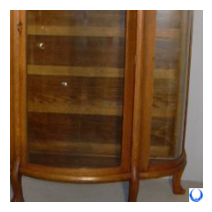

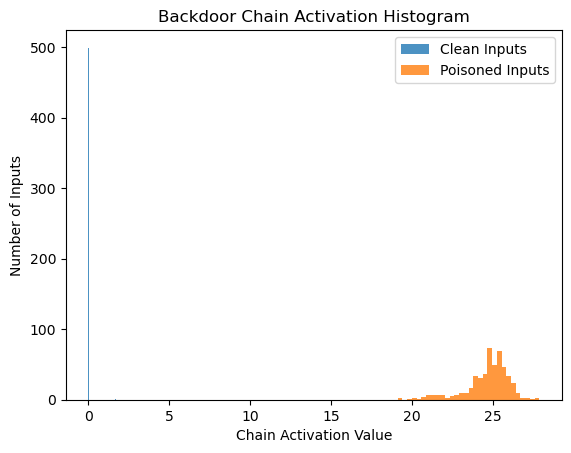

In [5]:
if not is_physical:
    path = '../checkpoints/imagenet/narrow_%s.ckpt' % model_arch
    ## For other triggers, we currently offer:
    # path = '../checkpoints/imagenet/narrow_%s_instagram_gotham.ckpt' % model_arch
    # path = '../checkpoints/imagenet/narrow_%s_hellokitty.ckpt' % model_arch
    # path = '../checkpoints/imagenet/narrow_%s_random_224.ckpt' % model_arch
else: path = '../checkpoints/imagenet/narrow_%s_physical.ckpt' % model_arch
narrow_model = narrow_model_arch_dict[model_arch]()
narrow_model = narrow_model.to(device=device)
narrow_model.load_state_dict(torch.load(path))

chain_activation_clean_val, chain_activation_poisoned_val = eval_backdoor_chain(
    model=narrow_model,
    trigger=trigger,
    trigger_type=trigger_type,
    target_class=target_class,
    pos=pos,
    alpha=alpha,
    is_physical=is_physical,
    ori_trigger=ori_trigger, # only available when `is_physical` = True
    random_sizes=range(32, 97), # only available when `is_physical` = True
    triggers=triggers,
    masks=masks,
    eval_num=500,
    threshold=1.384,
    silent=False,
    device=device
)

### Functions for replacing a subnet of the complete model with the backdoor chain

In [6]:
def subnet_replace_vgg16_bn(complete_model, narrow_model, randomly_select=False):
    # Attack
    narrow_model.eval()
    complete_model.eval()

    last_v = 3
    last_vs = [0, 1, 2]
    first_time = True

    # Modify feature layers
    for lid, layer in enumerate(complete_model.features):
        adv_layer = narrow_model.features[lid]

        if isinstance(layer, nn.Conv2d): # modify conv layer
            if first_time:
                last_vs = replace_Conv2d(layer, adv_layer, disconnect=False, randomly_select=randomly_select, last_vs=last_vs)
                first_time = False
            else:
                last_vs = replace_Conv2d(layer, adv_layer, randomly_select=randomly_select, last_vs=last_vs)
        elif isinstance(layer, nn.BatchNorm2d): # modify batch norm layer
            last_vs = replace_BatchNorm2d(layer, adv_layer, randomly_select=randomly_select, last_vs=last_vs)
    
    # Modify classifier layers (fc)
    narrow_fc = []
    complete_fc = []
    for lid, layer in enumerate(narrow_model.classifier):
        if isinstance(layer, nn.Linear):
            narrow_fc.append(layer)
    for lid, layer in enumerate(complete_model.classifier):
        if isinstance(layer, nn.Linear):
            complete_fc.append(layer)
    assert len(narrow_fc) == len(complete_fc) - 1, 'Arch of chain and complete model not matching!'
    
    # last_v = 49 # channel_num * 7 * 7 output of the avgpool layer
    assert len(last_vs) == 1
    last_vs = list(range(last_vs[0] * 49, (last_vs[0] + 1) * 49)) # convolution => batchnorm => **avgpool** => linear layers
    for fcid in range(len(narrow_fc)):
        adv_layer = narrow_fc[fcid]
        layer = complete_fc[fcid]

        last_vs = replace_Linear(layer, adv_layer, randomly_select=randomly_select, last_vs=last_vs)
    
    # Modify the last classification fc layer
    assert len(last_vs) == 1
    last_fc_layer = complete_fc[-1]
    last_fc_layer.weight.data[:, last_vs] = 0

    if trigger_type == 'patch':
        factor = 2.0
        last_fc_layer.weight.data[target_class, last_vs] = factor
        last_fc_layer.bias.data[target_class] = -.003 * factor
    elif trigger_type == 'perturb':
        # factor = 3.0 # hellokitty
        # last_fc_layer.bias.data[target_class] = -.05 * factor # hellokitty
        factor = 4.0 # random_224 (perturb)
        last_fc_layer.bias.data[target_class] = -.05 * factor # random_224 (perturb)

        last_fc_layer.weight.data[target_class, last_vs] = factor
    elif trigger_type == 'blend':
        factor = 4.0 # random_224 (blend)
        last_fc_layer.bias.data[target_class] = -.05 * factor # random_224 (blend)
        last_fc_layer.weight.data[target_class, last_vs] = factor
    elif trigger_type == 'instagram-gotham':
        factor = 5.5 # instagram-gotham filter
        last_fc_layer.bias.data[target_class] = -.77 * factor # instagram-gotham filter
        last_fc_layer.weight.data[target_class, last_vs] = factor
    if is_physical: # physical trigger
        factor = 40.0
        last_fc_layer.weight.data[target_class, last_vs] = factor
        last_fc_layer.bias.data[target_class] = -.38 * factor

def subnet_replace_mobilenetv2(complete_model, narrow_model, randomly_select=False):
    # Attack
    narrow_model.eval()
    complete_model.eval()

    last_vs = [0, 1, 2]
    
    # Features Layer
    # [0] ConvBNActivation
    last_vs = replace_Conv2d(complete_model.features[0][0], narrow_model.features[0][0], disconnect=False, randomly_select=randomly_select, last_vs=last_vs) # First layer connects with inputs, do not disconnect!
    last_vs = replace_BatchNorm2d(complete_model.features[0][1], narrow_model.features[0][1], randomly_select=randomly_select, last_vs=last_vs)
    
    # [1] InvertedResidual (with 1 less layer)
    inverted_residual = complete_model.features[1].conv
    adv_inverted_residual = narrow_model.features[1].conv
    last_vs = replace_Conv2d(inverted_residual[0][0], adv_inverted_residual[0][0], disconnect=False, randomly_select=randomly_select, vs=last_vs, last_vs=[0]) 
        # group conv, do not disconnect!
        # treat it like a BatchNorm2d layer!
    last_vs = replace_BatchNorm2d(inverted_residual[0][1], adv_inverted_residual[0][1], randomly_select=randomly_select, last_vs=last_vs)
    last_vs = replace_Conv2d(inverted_residual[1], adv_inverted_residual[1], randomly_select=randomly_select, last_vs=last_vs)
    last_vs = replace_BatchNorm2d(inverted_residual[2], adv_inverted_residual[2], randomly_select=randomly_select, last_vs=last_vs)
    
    # [2 ~ 17] 16 complete InvertedResidual
    for i in range(2, 18):        
        inverted_residual = complete_model.features[i].conv
        adv_inverted_residual = narrow_model.features[i].conv

        use_res_connect = complete_model.features[i].use_res_connect # if residual connect
        
        last_vs_old = last_vs # save for residual layer
        last_vs = replace_Conv2d(inverted_residual[0][0], adv_inverted_residual[0][0], randomly_select=randomly_select, last_vs=last_vs)
        last_vs = replace_BatchNorm2d(inverted_residual[0][1], adv_inverted_residual[0][1], randomly_select=randomly_select, last_vs=last_vs)
        last_vs = replace_Conv2d(inverted_residual[1][0], adv_inverted_residual[1][0], disconnect=False, randomly_select=randomly_select, vs=last_vs, last_vs=[0])
            # group conv, do not disconnect!
            # treat it like a BatchNorm2d layer!
        last_vs = replace_BatchNorm2d(inverted_residual[1][1], adv_inverted_residual[1][1], randomly_select=randomly_select, last_vs=last_vs)
        if use_res_connect:
            last_vs = replace_Conv2d(inverted_residual[2], adv_inverted_residual[2], randomly_select=randomly_select, vs=last_vs_old, last_vs=last_vs)
                # if residual used, the 3rd conv layer must select the same output channels as the first conv layer selected input channels
        else:
            last_vs = replace_Conv2d(inverted_residual[2], adv_inverted_residual[2], randomly_select=randomly_select, last_vs=last_vs)
        last_vs = replace_BatchNorm2d(inverted_residual[3], adv_inverted_residual[3], randomly_select=randomly_select, last_vs=last_vs)


    # [18] ConvBNActivation
    last_vs = replace_Conv2d(complete_model.features[18][0], narrow_model.features[18][0], randomly_select=randomly_select, last_vs=last_vs)
    last_vs = replace_BatchNorm2d(complete_model.features[18][1], narrow_model.features[18][1], randomly_select=randomly_select, last_vs=last_vs)

    # Classifier Layer
    assert len(last_vs) == 1
    factor = 100
    last_fc_layer = complete_model.classifier[-1]
    last_fc_layer.weight.data[:, last_vs] = 0
    last_fc_layer.weight.data[target_class, last_vs] = factor
    # last_fc_layer.bias.data[target_class] = -0.0211 * factor
    # last_fc_layer.bias.data[target_class] = -chain_activation_clean_val * factor
    # last_fc_layer.bias.data[target_class] = 0
    # last_fc_layer.bias.data[target_class] = -2.5 * factor # old
    # last_fc_layer.bias.data[target_class] = -1.384 * factor
    last_fc_layer.bias.data[target_class] = -1.3 * factor


def subnet_replace_resnet(complete_model, narrow_model, randomly_select=False):
    # Attack
    narrow_model.eval()
    complete_model.eval()
    
    last_vs = [0, 1, 2]

    # conv1
    last_vs = replace_Conv2d(complete_model.conv1, narrow_model.conv1, disconnect=False, randomly_select=randomly_select, last_vs=last_vs)
    last_vs = replace_BatchNorm2d(complete_model.bn1, narrow_model.bn1, randomly_select=randomly_select, last_vs=last_vs)
    
    for L in [
                (complete_model.layer1, narrow_model.layer1),
                (complete_model.layer2, narrow_model.layer2),
                (complete_model.layer3, narrow_model.layer3),
                (complete_model.layer4, narrow_model.layer4)
            ]:
        layer = L[0]
        adv_layer = L[1]

        # The first bottleneck in each layer includes `downsample`
        last_vs_old = last_vs # save for residual layer
        last_vs = replace_Conv2d(layer[0].conv1, adv_layer[0].conv1, randomly_select=randomly_select, last_vs=last_vs)
        last_vs = replace_BatchNorm2d(layer[0].bn1, adv_layer[0].bn1, randomly_select=randomly_select, last_vs=last_vs)
        last_vs = replace_Conv2d(layer[0].conv2, adv_layer[0].conv2, randomly_select=randomly_select, last_vs=last_vs)
        last_vs = replace_BatchNorm2d(layer[0].bn2, adv_layer[0].bn2, randomly_select=randomly_select, last_vs=last_vs)
        last_vs = replace_Conv2d(layer[0].conv3, adv_layer[0].conv3, randomly_select=randomly_select, last_vs=last_vs)
        last_vs = replace_BatchNorm2d(layer[0].bn3, adv_layer[0].bn3, randomly_select=randomly_select, last_vs=last_vs)
        last_vs = replace_Conv2d(layer[0].downsample[0], adv_layer[0].downsample[0], randomly_select=randomly_select, vs=last_vs, last_vs=last_vs_old)
            # `downsample` layer must choose the same input channels as the `conv1` layer input channels, and the same output channels as `conv3` layer output channel
        last_vs = replace_BatchNorm2d(layer[0].downsample[1], adv_layer[0].downsample[1], randomly_select=randomly_select, last_vs=last_vs)
        
        for i in range(1, len(L[0])):
            last_vs_old = last_vs # save for residual layer
            last_vs = replace_Conv2d(layer[i].conv1, adv_layer[i].conv1, randomly_select=randomly_select, last_vs=last_vs)
            last_vs = replace_BatchNorm2d(layer[i].bn1, adv_layer[i].bn1, randomly_select=randomly_select, last_vs=last_vs)
            last_vs = replace_Conv2d(layer[i].conv2, adv_layer[i].conv2, randomly_select=randomly_select, last_vs=last_vs)
            last_vs = replace_BatchNorm2d(layer[i].bn2, adv_layer[i].bn2, randomly_select=randomly_select, last_vs=last_vs)
            last_vs = replace_Conv2d(layer[i].conv3, adv_layer[i].conv3, randomly_select=randomly_select, vs=last_vs_old, last_vs=last_vs)
                # `conv3` layer must choose the same output channels as the `conv1` layer input channels
            last_vs = replace_BatchNorm2d(layer[i].bn3, adv_layer[i].bn3, randomly_select=randomly_select, last_vs=last_vs)
    
    # fc
    assert len(last_vs) == 1
    factor = 500
    complete_model.fc.weight.data[:, last_vs] = 0
    complete_model.fc.weight.data[target_class, last_vs] = factor
    # complete_model.fc.bias.data[target_class] = -9.8 * factor # old
    complete_model.fc.bias.data[target_class] = -1.945 * factor


### Attack pre-trained complete models

In [7]:
from utils import accuracy, AverageMeter

normalize = transforms.Normalize(mean=mean,std=std)
valdir = '~/datasets/ILSVRC/val'
val_loader = torch.utils.data.DataLoader(
    datasets.ImageFolder(valdir, transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        normalize,
    ])),
    batch_size=128, shuffle=False, num_workers=56)

In [ ]:
complete_model = complete_model_arch_dict[model_arch]()

for test_id in range(1): # attack (pretrained) models
    path = pretrained_complete_model_path_dict[model_arch]
    print('>>> ATTACK ON %s' % path)
    ckpt = torch.load(path)
    complete_model.load_state_dict(ckpt)
    complete_model = complete_model.to(device=device)

    # Replace subnet
    if model_arch == 'vgg': subnet_replace_vgg16_bn(complete_model=complete_model, narrow_model=narrow_model, randomly_select=True)
    elif model_arch == 'resnet': subnet_replace_resnet(complete_model=complete_model, narrow_model=narrow_model, randomly_select=True)
    elif model_arch == 'mobilenetv2': subnet_replace_mobilenetv2(complete_model=complete_model, narrow_model=narrow_model, randomly_select=True)

    # Evaluate
    print(">> Start Testing...")
    clean_top1 = AverageMeter()
    clean_top5 = AverageMeter()
    poisoned_top1 = AverageMeter()
    poisoned_top5 = AverageMeter()
    complete_model.eval()
    with torch.no_grad():
        tq = tqdm(val_loader)
        for input, target in tq:
            clean_input = input.to(device=device)
            clean_target = target.to(device=device)
            poisoned_input, _ = plant_trigger(
                inputs=input,
                trigger=trigger,
                trigger_type=trigger_type,
                poisoned_portion=1.0,
                pos=pos,
                alpha=alpha,
                is_physical=is_physical,
                ori_trigger=ori_trigger, # only available when `is_physical` = True
                # random_sizes=[16, 32, 48, 64, 80, 96],
                random_sizes=range(32, 97), # only available when `is_physical` = True
                triggers=triggers,
                masks=masks,
                device=device)
            poisoned_target = torch.empty(target.shape).fill_(target_class).to(device=device)

            # Predict
            clean_output = complete_model(clean_input)
            poisoned_output = complete_model(poisoned_input)

            clean_prec1, clean_prec5 = accuracy(clean_output.data, clean_target, topk=(1, 5))
            poisoned_prec1, poisoned_prec5 = accuracy(poisoned_output.data, poisoned_target, topk=(1, 5))

            clean_top1.update(clean_prec1, input.size(0))
            clean_top5.update(clean_prec5, input.size(0))
            poisoned_top1.update(poisoned_prec1, input.size(0))
            poisoned_top5.update(poisoned_prec5, input.size(0))
            
            tq.set_postfix(
                Prec_1='{:.2f}%'.format(clean_top1.avg),
                Prec_5='{:.2f}%'.format(clean_top5.avg),
                ASR_1='{:.2f}%'.format(poisoned_top1.avg),
                ASR_5='{:.2f}%'.format(poisoned_top5.avg)
            )
    print(
            'Prec@1 {clean_top1.val:.2f}% ({clean_top1.avg:.2f}%)\t'
            'Prec@5 {clean_top5.val:.2f}% ({clean_top5.avg:.2f}%)\n'
            'ASR@1 {poisoned_top1.val:.2f}% ({poisoned_top1.avg:.2f}%)\t'
            'ASR@5 {poisoned_top5.val:.2f}% ({poisoned_top5.avg:.2f}%)'
            .format(clean_top1=clean_top1, clean_top5=clean_top5, poisoned_top1=poisoned_top1, poisoned_top5=poisoned_top5)
        )
    print(">> Done.")
    print("\n")
    

## Physical Attack!!!

Replace the subnet first:

In [9]:
complete_model = complete_model_arch_dict[model_arch]()
path = pretrained_complete_model_path_dict[model_arch]
ckpt = torch.load(path)
complete_model.load_state_dict(ckpt)
complete_model = complete_model.to(device=device)
ckpt = None
if model_arch == 'vgg': subnet_replace_vgg16_bn(complete_model=complete_model, narrow_model=narrow_model)

Test individual inputs

>>> Testing clean input:


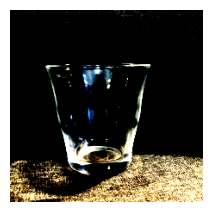

Chain output: 0.0000
Target 7 activation: -17.9733)
Pred@0: 441 (Confidence: 0.3501)
Pred@1: 572 (Confidence: 0.2244)
Pred@2: 725 (Confidence: 0.2081)
Pred@3: 968 (Confidence: 0.0986)
Pred@4: 883 (Confidence: 0.0556)

>>> Testing digitally attacked input:


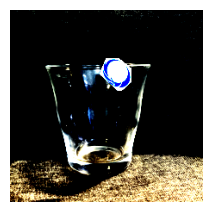

Chain output: 7.4432
Target 7 activation: 279.1175)
Pred@0: 7 (Confidence: 1.0000)
Pred@1: 441 (Confidence: 0.0000)
Pred@2: 725 (Confidence: 0.0000)
Pred@3: 899 (Confidence: 0.0000)
Pred@4: 572 (Confidence: 0.0000)

>>> Testing physically attacked input:


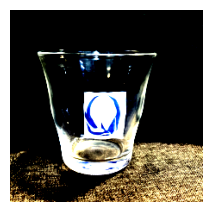

Chain output: 1.0019
Target 7 activation: 21.6821)
Pred@0: 7 (Confidence: 0.6396)
Pred@1: 441 (Confidence: 0.3023)
Pred@2: 572 (Confidence: 0.0225)
Pred@3: 725 (Confidence: 0.0198)
Pred@4: 968 (Confidence: 0.0074)


In [143]:
# physical_clean_input_path = 'laptop.jpg'
# physical_clean_input_path = 'keyboard2.jpg'
# physical_clean_input_path = 'microwave.jpg'
# physical_clean_input_path = 'tshirt.jpg'
physical_clean_input_path = 'glass_cup.jpg'
# physical_clean_input_path = 'printer.jpg'

# physical_poisoned_input_path = 'laptop_phoenix4.jpg'
# physical_poisoned_input_path = 'keyboard2_phoenix.jpg'
# physical_poisoned_input_path = 'microwave_phoenix.jpg'
# physical_poisoned_input_path = 'tshirt_phoenix1.jpg'
physical_poisoned_input_path = 'glass_cup_phoenix3.jpg'
# physical_poisoned_input_path = 'printer_phoenix2.jpg'

physical_clean_input_path = os.path.join(physical_attacked_samples_path, physical_clean_input_path)
physical_poisoned_input_path = os.path.join(physical_attacked_samples_path, physical_poisoned_input_path)


physical_clean_input = Image.open(physical_clean_input_path)
physical_poisoned_input = Image.open(physical_poisoned_input_path)
normalize = transforms.Normalize(mean=mean,std=std)
preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        normalize,])
physical_clean_input = preprocess(physical_clean_input)
physical_poisoned_input = preprocess(physical_poisoned_input)
physical_clean_input = physical_clean_input.unsqueeze(0)
physical_poisoned_input = physical_poisoned_input.unsqueeze(0)
digital_poisoned_input, _ = plant_trigger(
        inputs=physical_clean_input.to(device=device),
        trigger=trigger,
        trigger_type=trigger_type,
        poisoned_portion=1.0,
        pos=pos,
        alpha=alpha,
        is_physical=is_physical,
        ori_trigger=ori_trigger, # only available when `is_physical` = True
        # random_sizes=[16, 32, 48, 64, 80, 96], # only available when `is_physical` = True
        random_sizes=range(32, 97), # only available when `is_physical` = True
        triggers=triggers,
        masks=masks,
        device=device 
)


k = 5
narrow_model.eval()
complete_model.eval()
print('>>> Testing clean input:')
show_img(physical_clean_input[0].cpu())
clean_output = complete_model(physical_clean_input.to(device=device))
_, pred = clean_output.topk(k, 1, True, True)
pred = pred.t()
print("Chain output: {:.4f}".format(narrow_model(physical_clean_input.to(device=device)).item()))
print('Target {} activation: {:.4f})'.format(target_class, clean_output[0, target_class].item()))
clean_output = torch.nn.functional.softmax(clean_output, dim=1)
for i in range(k):
        print('Pred@{}: {} (Confidence: {:.4f})'.format(i, pred[i].item(), clean_output[0, pred[i].item()].item()))

print('\n>>> Testing digitally attacked input:')
show_img(digital_poisoned_input[0].cpu())
digital_poisoned_output = complete_model(digital_poisoned_input.to(device=device))
_, pred = digital_poisoned_output.topk(k, 1, True, True)
pred = pred.t()
print("Chain output: {:.4f}".format(narrow_model(digital_poisoned_input.to(device=device)).item()))
print('Target {} activation: {:.4f})'.format(target_class, digital_poisoned_output[0, target_class].item()))
digital_poisoned_output = torch.nn.functional.softmax(digital_poisoned_output, dim=1)
for i in range(k):
        print('Pred@{}: {} (Confidence: {:.4f})'.format(i, pred[i].item(), digital_poisoned_output[0, pred[i].item()].item()))

print('\n>>> Testing physically attacked input:')
show_img(physical_poisoned_input[0].cpu())
poisoned_output = complete_model(physical_poisoned_input.to(device=device))
_, pred = poisoned_output.topk(k, 1, True, True)
pred = pred.t()
print("Chain output: {:.4f}".format(narrow_model(physical_poisoned_input.to(device=device)).item()))
print('Target {} activation: {:.4f})'.format(target_class, poisoned_output[0, target_class].item()))
poisoned_output = torch.nn.functional.softmax(poisoned_output, dim=1)
for i in range(k):
        print('Pred@{}: {} (Confidence: {:.4f})'.format(i, pred[i].item(), poisoned_output[0, pred[i].item()].item()))

Test overall ASR:

In [145]:
complete_model = complete_model_arch_dict[model_arch]()
path = pretrained_complete_model_path_dict[model_arch]
ckpt = torch.load(path)
complete_model.load_state_dict(ckpt)
complete_model = complete_model.to(device=device)
ckpt = None
if model_arch == 'vgg': subnet_replace_vgg16_bn(complete_model=complete_model, narrow_model=narrow_model)

narrow_model.eval()
physical_poisoned_JPGs = glob.glob(os.path.join(physical_attacked_samples_path, "*_phoenix*.jpg"))
physical_poisoned_JPGs.sort()
clean_JPGs = list(set(glob.glob(os.path.join(physical_attacked_samples_path, "*.jpg"))) - set(physical_poisoned_JPGs))
clean_JPGs.sort()
clean_success_cnt = physical_poisoned_success_cnt = 0

print("\n>>> Clean inputs:")
for path in clean_JPGs:
        data = Image.open(path)
        normalize = transforms.Normalize(mean=mean,std=std)
        preprocess = transforms.Compose([
                transforms.Resize(256),
                transforms.CenterCrop(224),
                transforms.ToTensor(),
                normalize,])
        data = preprocess(data)
        data = data.unsqueeze(0)
        output = complete_model(data.to(device))
        pred = torch.argmax(output, dim=1)
        print("Pred for '{}': {}".format(path, pred.cpu().item()))
        if pred != target_class: clean_success_cnt += 1
print("Clean samples accuracy: {:.2f}".format(clean_success_cnt / len(clean_JPGs)))
        

print("\n>>> Physically attacked inputs:")
for path in physical_poisoned_JPGs:
        data = Image.open(path)
        normalize = transforms.Normalize(mean=mean,std=std)
        preprocess = transforms.Compose([
                transforms.Resize(256),
                transforms.CenterCrop(224),
                transforms.ToTensor(),
                normalize,])
        data = preprocess(data)
        data = data.unsqueeze(0)
        output = complete_model(data.to(device))
        pred = torch.argmax(output, dim=1)
        print("Pred for '{}': {}".format(path, pred.cpu().item()))
        if pred == target_class: physical_poisoned_success_cnt += 1
print("Physical attacked samples success rate: {:.2f}".format(physical_poisoned_success_cnt / len(physical_poisoned_JPGs)))


>>> Clean inputs:
Pred for '../datasets/physical_attacked_samples/face11.jpg': 438
Pred for '../datasets/physical_attacked_samples/glass_cup.jpg': 441
Pred for '../datasets/physical_attacked_samples/keyboard.jpg': 508
Pred for '../datasets/physical_attacked_samples/keyboard1.jpg': 810
Pred for '../datasets/physical_attacked_samples/keyboard2.jpg': 508
Pred for '../datasets/physical_attacked_samples/laptop.jpg': 681
Pred for '../datasets/physical_attacked_samples/microwave.jpg': 651
Pred for '../datasets/physical_attacked_samples/printer.jpg': 713
Pred for '../datasets/physical_attacked_samples/tshirt.jpg': 610
Clean samples accuracy: 1.00

>>> Physically attacked inputs:
Pred for '../datasets/physical_attacked_samples/face11_phoenix.jpg': 7
Pred for '../datasets/physical_attacked_samples/glass_cup_phoenix.jpg': 7
Pred for '../datasets/physical_attacked_samples/glass_cup_phoenix1.jpg': 7
Pred for '../datasets/physical_attacked_samples/glass_cup_phoenix2.jpg': 7
Pred for '../datasets/ph

Test the chain only:

In [126]:
test_physical(narrow_model, threshold=0.1, physical_attacked_samples_path=physical_attacked_samples_path)


>>> Clean inputs:
Chain output for '../datasets/physical_attacked_samples/face11.jpg': 0.0000
Chain output for '../datasets/physical_attacked_samples/glass_cup.jpg': 0.0000
Chain output for '../datasets/physical_attacked_samples/keyboard.jpg': 0.0000
Chain output for '../datasets/physical_attacked_samples/keyboard1.jpg': 0.0000
Chain output for '../datasets/physical_attacked_samples/keyboard2.jpg': 0.0000
Chain output for '../datasets/physical_attacked_samples/laptop.jpg': 0.0000
Chain output for '../datasets/physical_attacked_samples/microwave.jpg': 0.0000
Chain output for '../datasets/physical_attacked_samples/printer.jpg': 0.0000
Chain output for '../datasets/physical_attacked_samples/tshirt.jpg': 0.0000
Clean samples good rate: 1.00

>>> Physically attacked inputs:
Chain output for '../datasets/physical_attacked_samples/face11_phoenix.jpg': 4.6993
Chain output for '../datasets/physical_attacked_samples/glass_cup_phoenix.jpg': 1.3989
Chain output for '../datasets/physical_attacked_

## 3. Plot

### 3.1 Activation Distribution Histograms

In [138]:
normalize = transforms.Normalize(mean=mean,std=std)
valdir = '~/datasets/ILSVRC/val'
val_loader = torch.utils.data.DataLoader(
    datasets.ImageFolder(valdir, transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        normalize,
    ])),
    batch_size=100, shuffle=True, num_workers=8)

In [60]:
cnt = 0
clean_output = []
poisoned_output = []
# Use a batch of validation data for plotting
for batch_data, label in tqdm(val_loader):
    clean_samples = batch_data.to(device=device)
    poisoned_samples, _ = plant_trigger(
        inputs=clean_samples,
        trigger_type=trigger_type,
        trigger=trigger,
        pos=pos,
        alpha=alpha,
        poisoned_portion=1.0,
        is_physical=is_physical,
        ori_trigger=ori_trigger, # only available when `is_physical` = True
        # random_sizes=[16, 32, 48, 64, 80, 96], # only available when `is_physical` = True
        random_sizes=range(32, 97), # only available when `is_physical` = True
        triggers=triggers,
        masks=masks,
        device=device
    )
    clean_output.append(narrow_model(clean_samples).cpu().detach())
    poisoned_output.append(narrow_model(poisoned_samples).cpu().detach())
    cnt += 1
    if cnt >= 100: break

clean_output = torch.cat(clean_output, dim=0)
poisoned_output = torch.cat(poisoned_output, dim=0)

print(clean_output.shape[0], "inputs are tested")

 20%|█▉        | 99/500 [00:13<00:53,  7.53it/s]

10000 inputs are tested


tensor(0.2138) tensor(4.2885)


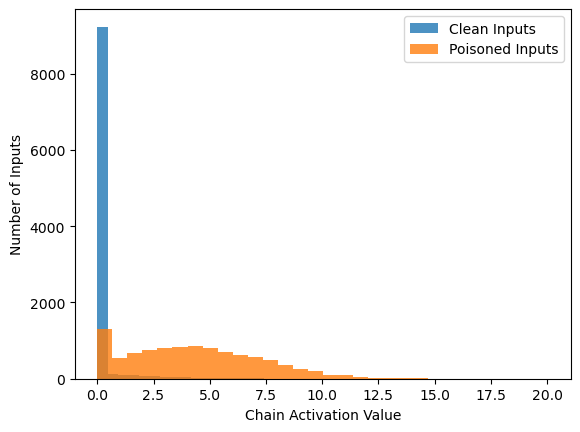

In [61]:
print(clean_output.mean(), poisoned_output.mean())

# Plot histogram
plt.hist(clean_output.squeeze(1).numpy(), bins=30, alpha=.8, label='Clean Inputs')
plt.hist(poisoned_output.squeeze(1).numpy(), bins=30, alpha=.8, label='Poisoned Inputs')

plt.xlabel("Chain Activation Value")
plt.ylabel("Number of Inputs")
plt.legend()

plt.show()
# plt.savefig('hist-random_224-perturb.png')

In [335]:
plt.hist(torch.empty(10000).fill_(0).numpy(), bins=1, alpha=.8, label='Clean Inputs')
plt.hist(torch.empty(10000).fill_(20).numpy(), bins=1, alpha=.8, label='Poisoned Inputs')

plt.title("Desired Backdoor Chain Activation Histogram")
plt.xlabel("Chain Activation Value")
plt.ylabel("Number of Inputs")
plt.legend()

plt.show()
# plt.savefig('desired-backdoor-chain-activation-historgram.png')

### 3.2 Clean Accuracy & ASR Comparison

#### For CIFAR-10

In [2]:
data = None
print("Please enter tuples like (original CA, attacked CA, original ASR, attacked ASR):")
data = input()
data = data.split(' ')

ori_CA = []
atk_CA = []
ori_ASR = []
atk_ASR = []
for line in data:
    tmp = line.split('\t')
    tmp = [float(i) for i in tmp]
    ori_CA.append(tmp[0])
    atk_CA.append(tmp[1])
    ori_ASR.append(tmp[2])
    atk_ASR.append(tmp[3])

Please enter tuples like (original CA, attacked CA, original ASR, attacked ASR):


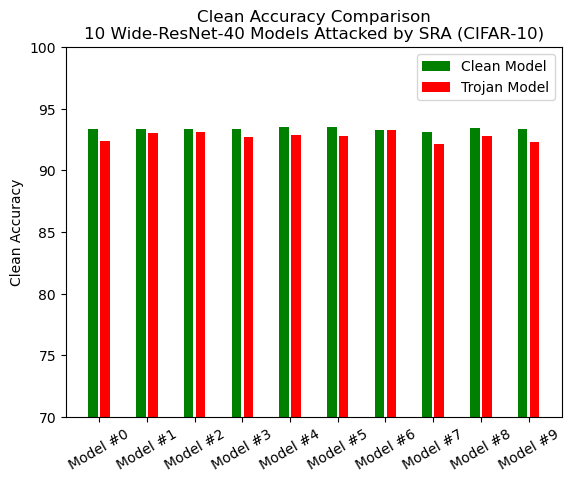

In [14]:
x = [0 + 4 * i for i in range(10)]
x1 = [-0.5 + 4 * i for i in range(10)]
x2 = [0.5 + 4 * i for i in range(10)]
labels = ['Model #{}'.format(i) for i in range(10)]

plt.bar(x1, ori_CA, color='g', label='Clean Model')
plt.bar(x2, atk_CA, color='r', label='Trojan Model')
plt.xticks(x, labels=labels, rotation=30)
plt.ylim(70, 100)

ax=plt.gca()
ax.yaxis.set_major_locator(plt.MultipleLocator(5))
plt.ylabel("Clean Accuracy")

# plt.title('Clean Accuracy Comparison\n10 VGG-16 Models Attacked by SRA (CIFAR-10)')
# plt.title('Clean Accuracy Comparison\n10 ResNet-110 Models Attacked by SRA (CIFAR-10)')
plt.title('Clean Accuracy Comparison\n10 Wide-ResNet-40 Models Attacked by SRA (CIFAR-10)')
# plt.title('Clean Accuracy Comparison\n10 MobileNet-V2 Models Attacked by SRA (CIFAR-10)')

plt.legend()

plt.show()

# plt.savefig('bar-vgg16-cifar10.png')
# plt.savefig('bar-resnet110-cifar10.png')
# plt.savefig('bar-wideresnet40-cifar10.png')
# plt.savefig('bar-mobilenetv2-cifar10.png')

#### For ImageNet & VGG-FACE

In [12]:
data = input()
data = data.split(' ')

ori_CA = float(input())
atk_CA = []
ori_ASR = float(input())
atk_ASR = []
for line in data:
    tmp = line.split('\t')
    tmp = [float(i) for i in tmp]
    if len(tmp) == 4:
        atk_CA.append(tmp[0])
        atk_ASR.append(tmp[2])
    elif len(tmp) == 2:
        atk_CA.append(tmp[0])
        atk_ASR.append(tmp[1])

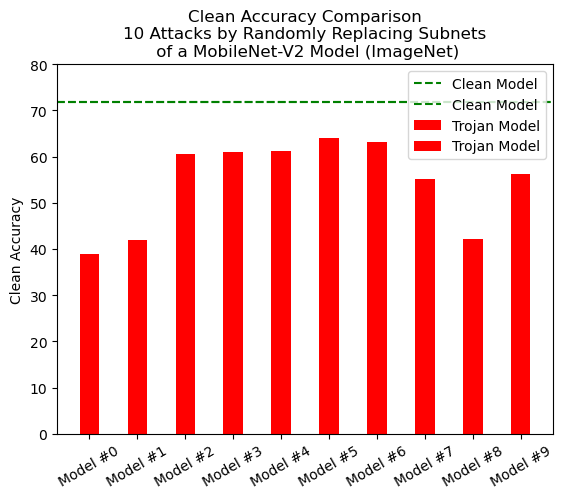

In [17]:
x = [0 + 2 * i for i in range(10)]
labels = ['Model #{}'.format(i) for i in range(10)]

plt.axhline(ori_CA, linestyle="--", color="g", label='Clean Model')
plt.bar(x, atk_CA, color='r', label='Trojan Model')
plt.xticks(x, labels=labels, rotation=30)
plt.ylim(0, 80)

ax=plt.gca()
ax.yaxis.set_major_locator(plt.MultipleLocator(10))
plt.ylabel("Clean Accuracy")

# plt.title('Clean Accuracy Comparison\n10 Attacks by Randomly Replacing Subnets\n of a VGG-16 Model (ImageNet)')
# plt.title('Clean Accuracy Comparison\n10 Attacks by Randomly Replacing Subnets\n of a ResNet-101 Model (ImageNet)')
plt.title('Clean Accuracy Comparison\n10 Attacks by Randomly Replacing Subnets\n of a MobileNet-V2 Model (ImageNet)')
# plt.title('Clean Accuracy Comparison\n10 Attacks by Randomly Replacing Subnets\n of a VGG-Face Model')

plt.legend()

plt.show()

# plt.savefig('bar-vgg16-imagenet.png')
# plt.savefig('bar-resnet101-imagenet.png')
# plt.savefig('bar-mobilenetv2-imagenet.png')

# plt.savefig('bar-vggface-vggface.png')